In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from cs231n.data_utils import load_CIFAR10_pytorch
from cs231n.classifiers.k_nearest_neighbor import KNN
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
datadir = './cs231n/datasets/'
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def imshow(img):
    plt.imshow(img.numpy().transpose((1, 2, 0)))

In [4]:
X_train, y_train, X_test, y_test = load_CIFAR10_pytorch(datadir)


In [5]:
print(X_train.size(), y_train.size(), X_test.size(), y_test.size())

torch.Size([50000, 3, 32, 32]) torch.Size([50000]) torch.Size([1000, 3, 32, 32]) torch.Size([1000])


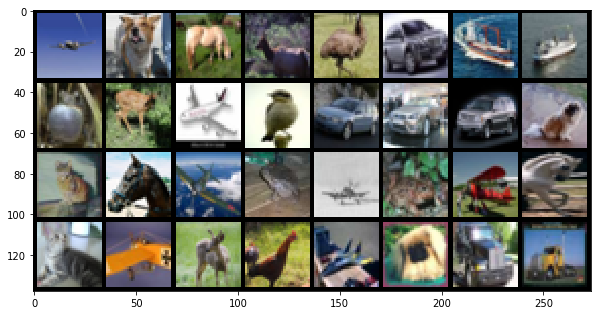

In [6]:
images = X_train[:32]
imshow(torchvision.utils.make_grid(images))

我们现在想用kNN分类器对测试数据进行分类。回想一下，我们可以将这个过程分解为两个步骤：

- 首先，我们必须计算所有测试示例和所有训练样本之间的距离。
- 给定这些距离，对于每个测试示例，我们找到k个最近的示例并让它们投票给标签

In [7]:
X_train = X_train[:5000]
X_test = X_test[:1000]
X_train = X_train.reshape(5000, -1)
X_test = X_test.reshape(1000, -1)

classifier = KNN()
classifier.train(X_train, y_train)

In [8]:
print(X_train.size(), X_test.size())

torch.Size([5000, 3072]) torch.Size([1000, 3072])


In [9]:
dists = classifier.compute_distance(X_test)
dists.size()

torch.Size([1000, 5000])

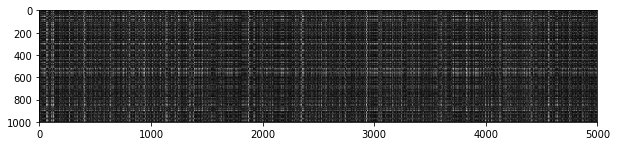

In [10]:
plt.imshow(dists, interpolation='none')
plt.show()

In [11]:
num_test = 1000
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = (y_test_pred == y_test).float().sum()
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 270 / 1000 correct => accuracy: 0.270000


## 交叉验证
We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.  
我们已经实现了KNN分类器，但我们是随意设置 k = 5。现在我们需要通过交叉验证来决定最佳的超参值

In [12]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
k_to_accuracies = {}

def CrossValidate(chunk, k, k_to_accuracies):
    for i in range(num_folds):
        beg = i * chunk
        end = beg + chunk
        X_train_temp = torch.cat((X_train[:beg, ], X_train[end:, ]), dim=0)
        y_train_temp = torch.cat((y_train[:beg, ], y_train[end:, ]), dim=0)
        cross_val_classifier.train(X_train_temp, y_train_temp)
        cross_val_dists = cross_val_classifier.compute_distance(X_train[beg:end,])
        cross_val_pred  = classifier.predict_labels(cross_val_dists, k=k)
        accuracy = (cross_val_pred == y_train[beg:end]).float().sum() / len(y_train[beg:end])
        if k in k_to_accuracies:
            k_to_accuracies[k].append(accuracy.item())
        else:
            k_to_accuracies[k] = [accuracy.item()]

chunk = int(len(X_train)/num_folds)
for k in k_choices:
    cross_val_classifier = KNN()
    CrossValidate(chunk, k, k_to_accuracies)
    

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.102000
k = 1, accuracy = 0.152000
k = 1, accuracy = 0.194000
k = 1, accuracy = 0.192000
k = 1, accuracy = 0.265000
k = 3, accuracy = 0.081000
k = 3, accuracy = 0.159000
k = 3, accuracy = 0.192000
k = 3, accuracy = 0.228000
k = 3, accuracy = 0.260000
k = 5, accuracy = 0.089000
k = 5, accuracy = 0.173000
k = 5, accuracy = 0.204000
k = 5, accuracy = 0.236000
k = 5, accuracy = 0.267000
k = 8, accuracy = 0.101000
k = 8, accuracy = 0.175000
k = 8, accuracy = 0.206000
k = 8, accuracy = 0.254000
k = 8, accuracy = 0.264000
k = 10, accuracy = 0.104000
k = 10, accuracy = 0.188000
k = 10, accuracy = 0.199000
k = 10, accuracy = 0.248000
k = 10, accuracy = 0.270000
k = 12, accuracy = 0.107000
k = 12, accuracy = 0.198000
k = 12, accuracy = 0.219000
k = 12, accuracy = 0.240000
k = 12, accuracy = 0.266000
k = 15, accuracy = 0.113000
k = 15, accuracy = 0.194000
k = 15, accuracy = 0.227000
k = 15, accuracy = 0.250000
k = 15, accuracy = 0.264000
k = 20, accuracy = 0.106000
k = 20, accu

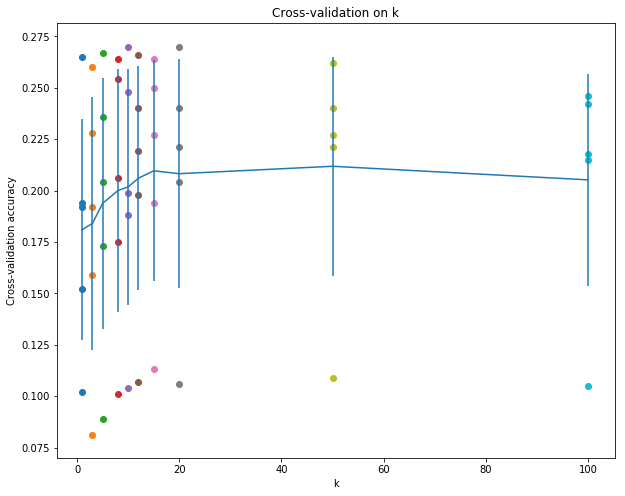

In [14]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [15]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 20

classifier = KNN()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = torch.sum(y_test_pred == y_test).item()
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 261 / 1000 correct => accuracy: 0.261000
